In [5]:
%ls

In [8]:
import json
import math
import copy

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [47]:
# file names to be analyzed

articles_file = "../data/articles.csv"
customers_file = "../data/customers.csv"
transactions_file = "../data/transactions_train.csv"

In [54]:
articles = pd.read_csv(articles_file)
customers = pd.read_csv(customers_file)
transactions = pd.read_csv(transactions_file)

Articles analysis first

In [12]:
articles = pd.read_csv(articles_file)
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [6]:
# check all columns for non-values, result is empty descriptions
articles.isna().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64


In [11]:
for col_name in ['article_id', "product_code", 'prod_name']:
  print(col_name, 'has only unique_values:', 
        articles[col_name].nunique() == articles.shape[0])

article_id has only unique_values: True
product_code has only unique_values: False
prod_name has only unique_values: False


In [ ]:
# product_code and prod_name have recurring values
print(articles['product_code'].nunique())
print(articles['prod_name'].nunique())

In [ ]:
articles["detail_desc"]

Descriptions are fairly brief, but non-values could be replaced by empty string for e.g. embeddings. If absolutely necessary, a model could be trained to generate descriptions based on images

When checking the description length, there is a large range of possibilities, longer descriptions generally hold more information

<ipython-input-31-84ac1f71931a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_splits['detail_desc'] = article_splits['detail_desc'].apply(lambda x: desc_length(x))
<ipython-input-31-84ac1f71931a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_splits.sort_values(by=['detail_desc'], inplace=True)


2
121
19     4313
18     4242
16     4225
20     4131
23     3972
       ... 
121       1
117       1
111       1
98        1
116       1
Name: detail_desc, Length: 105, dtype: int64


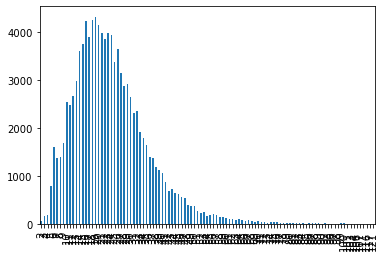

In [31]:
# consider description word counts, single word descriptions offer very little value
def desc_length(desc: str):
  return len(desc.split())

plt.locator_params(axis='x', nbins=10)
article_splits = articles.dropna(axis=0, subset=['detail_desc'])
article_splits['detail_desc'] = article_splits['detail_desc'].apply(lambda x: desc_length(x))
article_splits.sort_values(by=['detail_desc'], inplace=True)
print(min(article_splits['detail_desc']))
print(max(article_splits['detail_desc']))
print(article_splits['detail_desc'].value_counts())
vc = article_splits['detail_desc'].value_counts().sort_index()
vc.plot.bar()

Paired data should generally be identical due to redundancy, to check this columns should have an equal amount of unique values

In [32]:
print(articles[['product_type_no', 'product_type_name']].drop_duplicates().count())
print(articles[['graphical_appearance_no', 'graphical_appearance_name']].drop_duplicates().count())
print(articles[['colour_group_code', 'colour_group_name']].drop_duplicates().count())
print(articles[['perceived_colour_value_id', 'perceived_colour_value_name']].drop_duplicates().count())
print(articles[['perceived_colour_master_id', 'perceived_colour_master_name']].drop_duplicates().count())
print(articles[['department_no', 'department_name']].drop_duplicates().count())
print(articles[['index_code', 'index_name']].drop_duplicates().count())
print(articles[['index_group_no', 'index_group_name']].drop_duplicates().count())
print(articles[['section_no', 'section_name']].drop_duplicates().count())
print(articles[['garment_group_no', 'garment_group_name']].drop_duplicates().count())

product_type_no      132
product_type_name    132
dtype: int64
graphical_appearance_no      30
graphical_appearance_name    30
dtype: int64
colour_group_code    50
colour_group_name    50
dtype: int64
perceived_colour_value_id      8
perceived_colour_value_name    8
dtype: int64
perceived_colour_master_id      20
perceived_colour_master_name    20
dtype: int64
department_no      299
department_name    299
dtype: int64
index_code    10
index_name    10
dtype: int64
index_group_no      5
index_group_name    5
dtype: int64
section_no      57
section_name    57
dtype: int64
garment_group_no      21
garment_group_name    21
dtype: int64


Check for empty strings, these are similar to non-values, but indicate mistakes in the data

In [33]:
for name in ['product_type_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name',
             'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name',
             'garment_group_name']:
             print('empty values in', name, ":", articles[name][articles[name]==''].count())

# data seems to be clean going from this

empty values in product_type_name : 0
empty values in graphical_appearance_name : 0
empty values in colour_group_name : 0
empty values in perceived_colour_value_name : 0
empty values in perceived_colour_master_name : 0
empty values in department_name : 0
empty values in index_name : 0
empty values in index_group_name : 0
empty values in section_name : 0
empty values in garment_group_name : 0


customer analysis

In [34]:
customers = pd.read_csv(customers_file)
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


Checking for null values first

In [41]:
print(customers.isna().sum())
print(customers.isna().sum()/customers.count())

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64
customer_id               0.000000
FN                        1.876690
Active                    1.954281
club_member_status        0.004438
fashion_news_frequency    0.011806
age                       0.011696
postal_code               0.000000
dtype: float64


Data here seems considerably more messy, over half of customers have no FN or activity status

In [42]:
# Inspecting FN values
customers['FN'].drop_duplicates()

0    NaN
4    1.0
Name: FN, dtype: float64

looking at general age distribution, for this NaN should be ignored

3
19


<ipython-input-44-3543a3bdfaae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aged_customers['age'] = aged_customers['age'].apply(lambda x: batch_age(x))


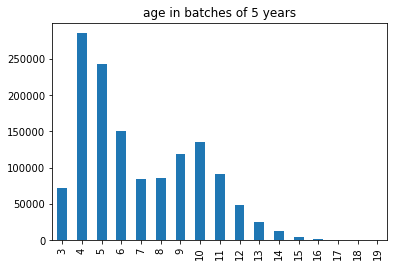

In [44]:
# batch ages for
def batch_age(x: int, batch_width: int = 5):
  return math.floor(x/batch_width)

aged_customers = customers.dropna(axis=0, subset=['age'])
aged_customers['age'] = aged_customers['age'].apply(lambda x: batch_age(x))
print(min(aged_customers['age']))
print(max(aged_customers['age']))
aged_customers['age'].value_counts().sort_index().plot.bar(title="age in batches of 5 years")

Even when batched, it is apparent that there are significant portions of the space that do not have any entries, if this expands to the full dataset, we might not be able to use age-based features equally well at all times

Transactions analysis

In [55]:
transactions = pd.read_csv(transactions_file)
print(transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB
None


In [56]:
print(transactions.isna().sum())

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64


Considerably more clean data, ordered can be ignored as this is artificial data

In [57]:
unique_customers = customers['customer_id']
unique_buying_customers = transactions['customer_id'].drop_duplicates()
print(unique_customers.count() - unique_buying_customers.count(), "customers have not bought anything")

9699 customers have not bought anything


Customers that have never bought anything are a special case, generally people will only make an account the moment they want to buy something. It is not possible to provide a properly personalized set of recommendations for these customers, meaning we might have to resort to recently popular items

In [ ]:
unique_articles = articles['article_id']
unique_bought_articles = transactions['article_id'].drop_duplicates()
print(unique_articles.count() - unique_bought_articles.count(), "articles have never been bought")

0 articles have never been bought


The other side of the equation would be articles that nobody buys, as we need a different approach from buying behavior to determine similar items

Checking whether people tend to buy the same thing twice, some customers do, and the amount of times they do so varies. This might be depending on for instance the type of clothing bought

customer_id
003a5fe0262e869317000bb40926dd19d450a52e938244c0a66d5ae71058c7c7     7
0117b860a8a11a81eaa1c6825c6af18725c5406223c02cac2518a793e3e7778b     7
01580afe0d488ebe9339c0599beff0b3cb8e3eae988bd033ac917b9b7833542e    12
019db1566c30e1fe94ed2013daac827c05d91ca83eb7fc37378d42f6a911b1d3     2
020cf64547618c64d765e382f2b0a7c64afbf827d280d4c1d0991d26284cd179     1
                                                                    ..
fdc53a7ef3a228d6101c8463d2c2bd2ed5eb126ec0461f8e5745f869d9d6befa    15
fe3882a8267fa5531ea15da8f82a1bf77ceb06aa43345c77208021c86f072688     3
fedd455c59bda34f591fdb223394337471605304d1297e760869d09c7251431a     1
feeea1067411a83c80df6f3f0f3d9eaaed9e6bc6e95c823f0d5de98f906f9126    11
ffe29026e0f2f2ef492830b24cc76f445fd89a70488892428200f0b0226934d8     2
Length: 645, dtype: int64


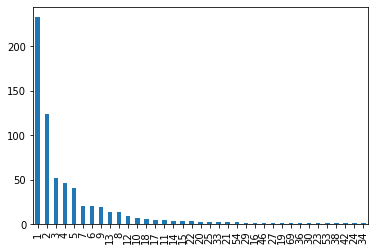

In [35]:
t_frame = transactions.groupby(by=['customer_id', 'article_id'])
t_list = t_frame.size()[t_frame.size() > 1]
print(t_list.groupby(['customer_id']).count())
t_list.groupby(['customer_id']).count().value_counts().plot.bar()